# Active Sensing Feature Extraction

## Introduction

In this example we load in a raw set of active sensing data, process it according to the geometry of the plate structure, and extract features relative to the presence of damage.

The test structure was a 0.01 inch concave-shaped plate approximately 48 inches on one side. The plate was instrumented with 32 piezoelectric transducers which served as both actuators and sensors to form 492 actuator-sensor pairs. Damage was simulated using a two inch neodymium magnet.

The data acquisition system cycled through the actuator-sensor pairs, one at a time, inducing a gaussian windowed sinusoid at the actuator and sensing the propagated wave at the sensor. This was done once before damage was applied and then again after damage. It is assumed that the damage modifies the received waveform through scattering.

This example builds an array of points on the structure for detecting damage at. Individual features are then extracted from the measured waveforms by estimating the wave group velocity and establishing line-of-sight constraints. The final result is a map of the sums of the feature vectors at each point on the structure.

For proper structural health monitoring, the features produced in this example need to be used to build and test against a statistical model in order to decide the damage state of the structure.

**SHMTools functions used:**
- `import_ActiveSense1_shm`
- `struct_cell_2_mat_shm`
- `reduce_2_pair_subset_shm`
- `build_contained_grid_shm`
- `propagation_dist_2_points_shm`
- `get_prop_dist_2_boundary_shm`
- `sensor_pair_line_of_sight_shm`
- `estimate_group_velocity_shm`
- `distance_2_index_shm`
- `incoherent_matched_filter_shm`
- `extract_subsets_shm`
- `flex_logic_filter_shm`
- `sum_mult_dims_shm`
- `fill_2d_map_shm`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import import_active_sense1_shm
from shmtools.active_sensing import (
    struct_cell_2_mat_shm, reduce_2_pair_subset_shm, build_contained_grid_shm,
    propagation_dist_2_points_shm, get_prop_dist_2_boundary_shm,
    sensor_pair_line_of_sight_shm, estimate_group_velocity_shm,
    distance_2_index_shm, incoherent_matched_filter_shm,
    extract_subsets_shm, flex_logic_filter_shm, sum_mult_dims_shm,
    fill_2d_map_shm
)

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

/Users/eric/repo/shm/shmtools/classification/nlpca.py:27: UserWarning: TensorFlow not available. NLPCA functions will not work. Install TensorFlow: pip install tensorflow
  warnings.warn(


## Configuration Parameters

In [2]:
# Select subset (or all) of sensors to process (0-31) - MATLAB: [0 2 5 7 11 12 15 17 19 21 24 25 27 28 30]
sensor_subset = np.array([0, 2, 5, 7, 11, 12, 15, 17, 19, 21, 24, 25, 27, 28, 30])

# Resolution, in inches, of imaging on plate
POI_spacing = 0.5

# Sample actuator-sensor pair index for plotting
sample_pair_i = 4

print(f"Sensor subset: {sensor_subset}")
print(f"POI spacing: {POI_spacing} inches")
print(f"Sample pair index: {sample_pair_i}")

Sensor subset: [ 0  2  5  7 11 12 15 17 19 21 24 25 27 28 30]
POI spacing: 0.5 inches
Sample pair index: 4


## Load Data and DAQ Parameters

In [3]:
# Load the data - MATLAB: load('data_example_ActiveSense.mat',...)
(
    waveform_base,
    waveform_test,
    sensor_layout,
    pair_list,
    border_struct,
    sample_rate,
    actuation_waveform,
    damage_location,
) = import_active_sense1_shm()

print(f"Data loaded successfully!")
print(f"Waveform base shape: {waveform_base.shape}")
print(f"Waveform test shape: {waveform_test.shape}")
print(f"Sensor layout shape: {sensor_layout.shape}")
print(f"Pair list shape: {pair_list.shape}")
print(f"Sample rate: {sample_rate} Hz")
print(f"Actuation waveform shape: {actuation_waveform.shape}")
print(f"Damage location: {damage_location.flatten()}")

Data loaded successfully!
Waveform base shape: (10000, 496)
Waveform test shape: (10000, 496)
Sensor layout shape: (3, 32)
Pair list shape: (2, 496)
Sample rate: 5000000.0 Hz
Actuation waveform shape: (469, 1)
Damage location: [43.  16.5]


## Collect Border Line Segments into One Array

In [4]:
# The line segments defining the border are stored as a structure.
# Combine them into a single array by concatenating them.
# MATLAB: borderComb=structCell2Mat_shm(borderStruct);
border_comb = struct_cell_2_mat_shm(border_struct)

print(f"Border combined shape: {border_comb.shape}")
print(f"Border structure keys: {list(border_struct.keys()) if isinstance(border_struct, dict) else 'Not a dict'}")

Border combined shape: (4, 8)
Border structure keys: ['outside']


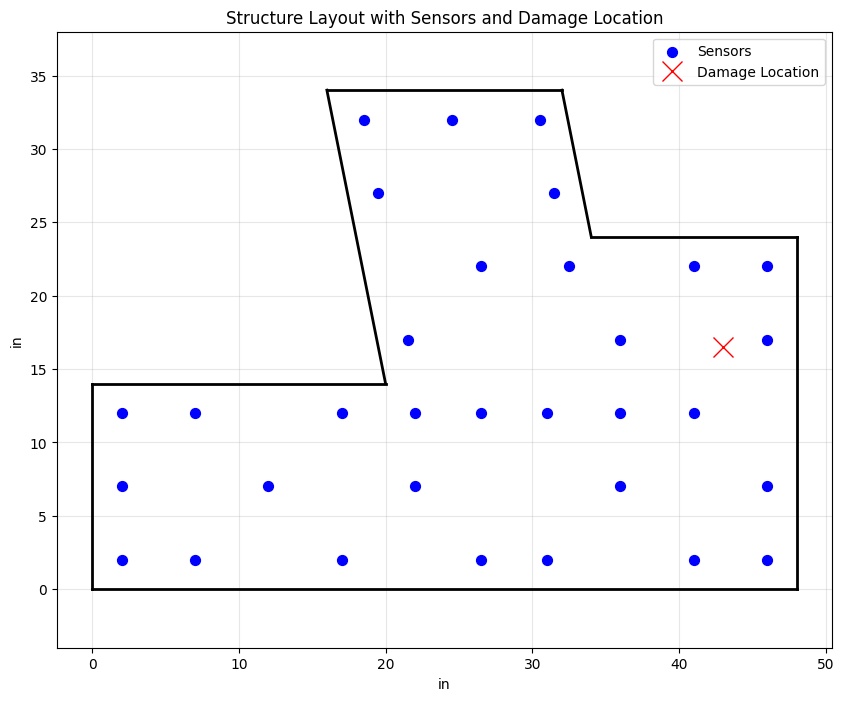

In [5]:
# Plot the boundaries, sensors, and damage location
plt.figure(figsize=(10, 8))

# Plot sensors (MATLAB format: sensor_layout is 3 x N_SENSORS)
if sensor_layout.shape[0] == 3:  # [sensorID, xCoord, yCoord]
    sensor_x = sensor_layout[1, :]
    sensor_y = sensor_layout[2, :]
else:  # Transposed format
    sensor_x = sensor_layout[:, 1]
    sensor_y = sensor_layout[:, 2]

plt.scatter(sensor_x, sensor_y, c='blue', s=50, marker='o', label='Sensors')

# Plot damage location
if damage_location.ndim > 1:
    damage_x, damage_y = damage_location[0, 0], damage_location[1, 0]
else:
    damage_x, damage_y = damage_location[0], damage_location[1]
    
plt.plot(damage_x, damage_y, 'xr', markersize=15, linewidth=4, label='Damage Location')

# Plot border if available
if border_comb.size > 0:
    if border_comb.shape[0] == 4:  # [x1, y1, x2, y2] format
        for i in range(border_comb.shape[1]):
            x1, y1, x2, y2 = border_comb[:, i]
            plt.plot([x1, x2], [y1, y2], 'k-', linewidth=2)

plt.xlabel('in')
plt.ylabel('in')
plt.legend()
plt.axis('equal')
plt.title('Structure Layout with Sensors and Damage Location')
plt.grid(True, alpha=0.3)
plt.show()

## Extract Data for Sensor Subset

In [6]:
# Extract the data relevant to the chosen subset of sensors
# MATLAB: [pairListSub, sensorLayoutSub, waveformBaseSub, waveformTestSub] = 
#         reduce2PairSubset_shm(sensorSubset, sensorLayout, pairList, waveformBase, waveformTest);

pair_list_sub, sensor_layout_sub, waveform_base_sub, waveform_test_sub = reduce_2_pair_subset_shm(
    sensor_subset, sensor_layout, pair_list, waveform_base, waveform_test
)

print(f"Pair list subset shape: {pair_list_sub.shape}")
print(f"Sensor layout subset shape: {sensor_layout_sub.shape}")
print(f"Waveform base subset shape: {waveform_base_sub.shape if waveform_base_sub is not None else 'None'}")
print(f"Waveform test subset shape: {waveform_test_sub.shape if waveform_test_sub is not None else 'None'}")

Pair list subset shape: (2, 105)
Sensor layout subset shape: (3, 15)
Waveform base subset shape: (10000, 105)
Waveform test subset shape: (10000, 105)


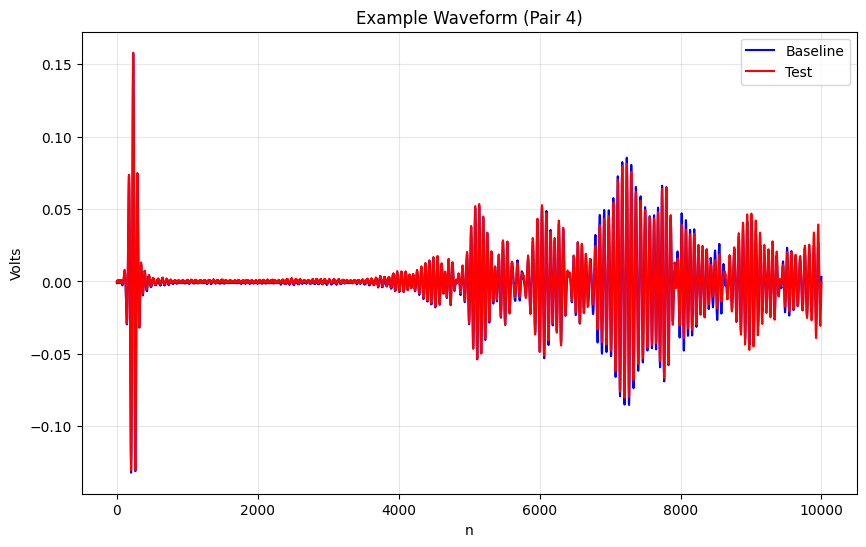

In [7]:
# Plot an example waveform
if waveform_base_sub is not None and waveform_test_sub is not None:
    plt.figure(figsize=(10, 6))
    
    # MATLAB indexing: waveformBaseSub(:, samplePairI, 1)
    if sample_pair_i < waveform_base_sub.shape[1]:
        time_points = np.arange(waveform_base_sub.shape[0])
        
        if waveform_base_sub.ndim == 3:
            baseline_signal = waveform_base_sub[:, sample_pair_i, 0]
            test_signal = waveform_test_sub[:, sample_pair_i, 0]
        else:
            baseline_signal = waveform_base_sub[:, sample_pair_i]
            test_signal = waveform_test_sub[:, sample_pair_i]
        
        plt.plot(time_points, baseline_signal, 'b-', label='Baseline')
        plt.plot(time_points, test_signal, 'r-', label='Test')
        
        plt.xlabel('n')
        plt.ylabel('Volts')
        plt.legend()
        plt.title(f'Example Waveform (Pair {sample_pair_i})')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Sample pair index {sample_pair_i} exceeds number of pairs {waveform_base_sub.shape[1]}")

## Build Contained Grid of Points

In [8]:
# Construct uniform list of points of interest (POIs)
# MATLAB: [pointList, pointMask, xMatrix, yMatrix] = buildContainedGrid_shm(borderStruct, xSpacing, ySpacing);

x_spacing = POI_spacing
y_spacing = POI_spacing

# Convert border_struct to proper format for build_contained_grid_shm
if isinstance(border_struct, dict):
    border_list = []
    for key, value in border_struct.items():
        if hasattr(value, 'shape') and value.size > 0:
            if value.shape[0] == 4:  # [x1, y1, x2, y2] format - convert to [x, y] vertex list
                # Convert line segments to vertex list
                vertices = []
                for i in range(value.shape[1]):
                    x1, y1, x2, y2 = value[:, i]
                    if i == 0:
                        vertices.append([x1, y1])
                    vertices.append([x2, y2])
                border_list.append(np.array(vertices))
            else:
                border_list.append(value)
else:
    border_list = [border_struct] if hasattr(border_struct, 'shape') else []

try:
    point_list, point_mask, x_matrix, y_matrix = build_contained_grid_shm(
        border_list, x_spacing, y_spacing
    )
    print(f"Grid built successfully")
    print(f"Point list shape: {point_list.shape}")
    print(f"Point mask shape: {point_mask.shape}")
    print(f"X matrix shape: {x_matrix.shape}")
    print(f"Y matrix shape: {y_matrix.shape}")
except Exception as e:
    print(f"Error building grid: {e}")
    # Create a simple rectangular grid as fallback
    x_min, x_max = np.min(sensor_x), np.max(sensor_x)
    y_min, y_max = np.min(sensor_y), np.max(sensor_y)
    
    x_range = np.arange(x_min, x_max + x_spacing, x_spacing)
    y_range = np.arange(y_min, y_max + y_spacing, y_spacing)
    x_matrix, y_matrix = np.meshgrid(x_range, y_range)
    
    point_list = np.column_stack([x_matrix.flatten(), y_matrix.flatten()])
    point_mask = np.ones(x_matrix.shape, dtype=bool)
    
    print(f"Created fallback grid: {point_list.shape[0]} points")

Grid built successfully
Point list shape: (4526, 2)
Point mask shape: (70, 98)
X matrix shape: (70, 98)
Y matrix shape: (70, 98)


## Propagation Distance to Points

In [9]:
# Calculate propagation distance from transducer pairs to POIs
# MATLAB: propDistance=propagationDist2Points_shm(pairListSub,sensorLayoutSub,pointList);

# Ensure point_list is in the right format (2 x N_POINTS for MATLAB compatibility)
if point_list.shape[1] == 2:
    point_list_matlab = point_list.T  # Convert to 2 x N_POINTS
else:
    point_list_matlab = point_list

prop_distance = propagation_dist_2_points_shm(pair_list_sub, sensor_layout_sub, point_list_matlab)

print(f"Propagation distance matrix shape: {prop_distance.shape}")
print(f"Distance range: {np.min(prop_distance):.3f} - {np.max(prop_distance):.3f} inches")

Propagation distance matrix shape: (105, 4526)
Distance range: 7.071 - 98.504 inches


## Propagation Distance to Boundary

In [10]:
# Calculate the propagation distance from transducer pairs to boundaries
# MATLAB: [propDist,minPropDist] = getPropDist2Boundary_shm(pairListSub, sensorLayoutSub, borderComb);

if border_comb.size > 0:
    prop_dist, min_prop_dist = get_prop_dist_2_boundary_shm(pair_list_sub, sensor_layout_sub, border_comb)
    
    print(f"Propagation distance to boundary shape: {prop_dist.shape}")
    print(f"Min propagation distance shape: {min_prop_dist.shape}")
    print(f"Boundary distance range: {np.min(min_prop_dist):.3f} - {np.max(min_prop_dist):.3f} inches")
else:
    print("No border data available for boundary distance calculation")
    # Create dummy data
    prop_dist = np.ones((pair_list_sub.shape[1], 1)) * 1000  # Large distances
    min_prop_dist = np.ones(pair_list_sub.shape[1]) * 1000

Propagation distance to boundary shape: (105, 8)
Min propagation distance shape: (105,)
Boundary distance range: 10.313 - 47.812 inches


## Line of Sight

In [11]:
# Determine line of sight from transducer pairs to POIs
# MATLAB: [pairLineOfSight sensorLineOfSight] = sensorPairLineOfSight_shm(pairListSub, sensorLayoutSub, pointList, borderComb);

if border_list:
    pair_line_of_sight = sensor_pair_line_of_sight_shm(
        pair_list_sub, sensor_layout_sub, point_list_matlab, border_list
    )
    
    print(f"Pair line of sight shape: {pair_line_of_sight.shape}")
    print(f"Line of sight fraction: {np.mean(pair_line_of_sight):.3f}")
else:
    print("No border data available - assuming all pairs have line of sight")
    pair_line_of_sight = np.ones((pair_list_sub.shape[1], point_list_matlab.shape[1]), dtype=bool)

Pair line of sight shape: (105, 4526)
Line of sight fraction: 0.747


## Distance Compare

In [12]:
# Compare the distance to the POIs to the distance to the nearest boundary
# MATLAB: distance=propDistance; maxDistance=minPropDist; distanceAllowance=0;
# MATLAB: [belowMaxDistance]=bsxfun(@lt,distance-distanceAllowance,maxDistance);

distance = prop_distance
max_distance = min_prop_dist
distance_allowance = 100

# Broadcasting comparison: distance - allowance < max_distance for each pair
below_max_distance = (distance - distance_allowance) < max_distance[:, np.newaxis]

print(f"Below max distance shape: {below_max_distance.shape}")
print(f"Fraction of points below max distance: {np.mean(below_max_distance):.3f}")

Below max distance shape: (105, 4526)
Fraction of points below max distance: 1.000


## Estimate Group Velocity

In [13]:
# Filter the waveforms and estimate group velocity
# MATLAB: waveform=waveformBaseSub; matchedWaveform=actuationWaveform;
# MATLAB: filteredWaveform2=incoherentMatchedFilter_shm(waveform,matchedWaveform);

waveform = waveform_base_sub
matched_waveform = actuation_waveform

# Apply matched filter
filtered_waveform2 = incoherent_matched_filter_shm(waveform, matched_waveform)

print(f"Filtered waveform shape: {filtered_waveform2.shape}")

# Calculate the group velocity
# MATLAB: waveform=filteredWaveform2; actuationWidth=length(actuationWaveform); lineOfSight=[];
# MATLAB: [estSpeed, speedList]=estimateGroupVelocity_shm(waveform, pairListSub, sensorLayoutSub, sampleRate, actuationWidth, lineOfSight);

waveform_for_velocity = filtered_waveform2
actuation_width = len(actuation_waveform)
line_of_sight = None  # Empty in MATLAB

est_speed, speed_list = estimate_group_velocity_shm(
    waveform_for_velocity, pair_list_sub, sensor_layout_sub, sample_rate, actuation_width, line_of_sight
)

print(f"Estimated speed: {est_speed:.0f} units/s")
print(f"Speed list length: {len(speed_list)}")
if len(speed_list) > 0:
    print(f"Speed range: {np.min(speed_list):.0f} - {np.max(speed_list):.0f} units/s")

est_speed = 66000

Filtered waveform shape: (10000, 105)
Estimated speed: 454502 units/s
Speed list length: 105
Speed range: 23118 - 1001865 units/s


## Distance 2 Index

In [14]:
# Translate propagation distances to waveform indices using group velocity
# MATLAB: wavespeed=estSpeed; offset=actuationWaveform;
# MATLAB: indices=distance2Index_shm(propDistance,sampleRate,wavespeed,offset);

wavespeed = est_speed
offset = actuation_waveform  # This will be converted to time offset internally

indices = distance_2_index_shm(prop_distance, sample_rate, wavespeed, offset)

print(f"Indices shape: {indices.shape}")
print(f"Index range: {np.min(indices)} - {np.max(indices)}")

Indices shape: (105, 4526)
Index range: 770 - 7697


## Difference

Data difference shape: (10000, 105)


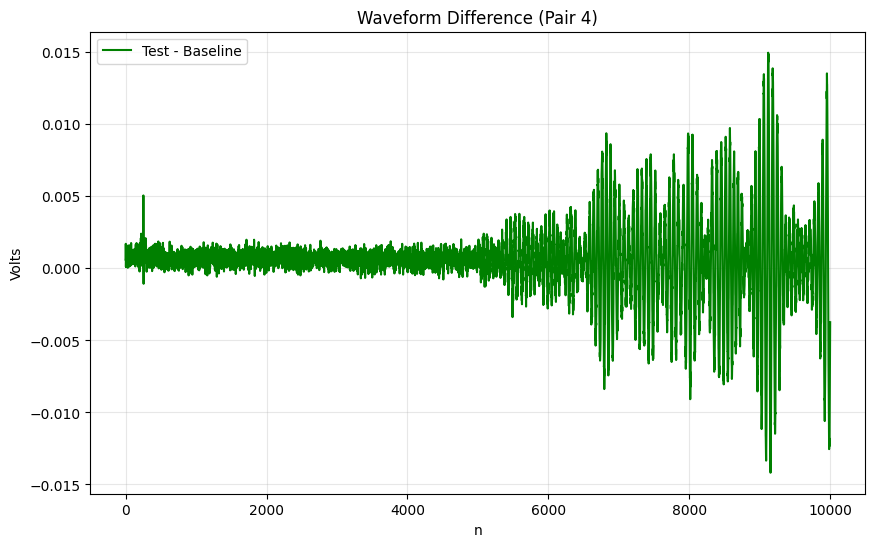

In [15]:
# Subtract the baseline waveforms from the test waveforms
# MATLAB: dataDifference=waveformTestSub-waveformBaseSub;

data_difference = waveform_test_sub - waveform_base_sub

print(f"Data difference shape: {data_difference.shape}")

# Plot sample waveform difference
if sample_pair_i < data_difference.shape[1]:
    plt.figure(figsize=(10, 6))
    
    if data_difference.ndim == 3:
        diff_signal = data_difference[:, sample_pair_i, 0]
    else:
        diff_signal = data_difference[:, sample_pair_i]
    
    plt.plot(diff_signal, 'g-', label='Test - Baseline')
    plt.xlabel('n')
    plt.ylabel('Volts')
    plt.legend()
    plt.title(f'Waveform Difference (Pair {sample_pair_i})')
    plt.grid(True, alpha=0.3)
    plt.show()

## Incoherent Matched Filter

Filtered waveform shape: (10000, 105)


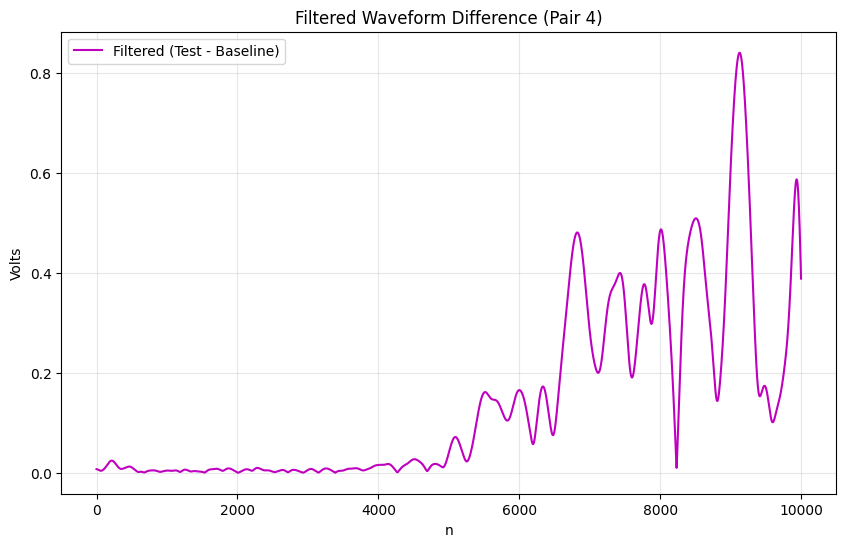

In [16]:
# Apply incoherent matched filter to waveform difference
# MATLAB: waveform=dataDifference; matchedWaveform=actuationWaveform;
# MATLAB: filteredWaveform=incoherentMatchedFilter_shm(waveform,matchedWaveform);

waveform = data_difference
matched_waveform = actuation_waveform

filtered_waveform = incoherent_matched_filter_shm(waveform, matched_waveform)

print(f"Filtered waveform shape: {filtered_waveform.shape}")

# Plot sample filtered waveform difference
if sample_pair_i < filtered_waveform.shape[1]:
    plt.figure(figsize=(10, 6))
    
    if filtered_waveform.ndim == 3:
        filtered_signal = filtered_waveform[:, sample_pair_i, 0]
    else:
        filtered_signal = filtered_waveform[:, sample_pair_i]
    
    plt.plot(filtered_signal, 'm-', label='Filtered (Test - Baseline)')
    plt.xlabel('n')
    plt.ylabel('Volts')
    plt.legend()
    plt.title(f'Filtered Waveform Difference (Pair {sample_pair_i})')
    plt.grid(True, alpha=0.3)
    plt.show()

## Extract Subset

In [17]:
# Extract the matched filter value for each POI using time of flight indices
# MATLAB: data=filteredWaveform; startIndices=indices; subsetLength=1;
# MATLAB: dataSubset=extractSubsets_shm(data,startIndices,subsetLength);

data = filtered_waveform
start_indices = indices
subset_length = 1

data_subset = extract_subsets_shm(data, start_indices, subset_length)

print(f"Data subset shape: {data_subset.shape}")
print(f"Data subset range: {np.min(data_subset):.2e} - {np.max(data_subset):.2e}")

Data subset shape: (105, 4526, 1)
Data subset range: 1.08e-04 - 3.28e+00


## Apply Logic Filters

In [18]:
# Zero-out contributions from transducer pairs without line of sight
# MATLAB: data=dataSubset; logicFilter=pairLineOfSight;
# MATLAB: [filteredData]=flexLogicFilter_shm(data,logicFilter);

data = data_subset
logic_filter = pair_line_of_sight

filtered_data = flex_logic_filter_shm(data, logic_filter)

print(f"Filtered data (line of sight) shape: {filtered_data.shape}")
print(f"Non-zero fraction after LOS filter: {np.mean(filtered_data != 0):.3f}")

Filtered data (line of sight) shape: (105, 4526, 1)
Non-zero fraction after LOS filter: 0.747


In [19]:
# Zero-out contributions from transducer pairs that are closer to a boundary than the POIs
# MATLAB: data=filteredData; logicFilter=belowMaxDistance;
# MATLAB: [filteredData]=flexLogicFilter_shm(data,logicFilter);

data = filtered_data
logic_filter = below_max_distance

filtered_data = flex_logic_filter_shm(data, logic_filter)

print(f"Filtered data (distance) shape: {filtered_data.shape}")
print(f"Non-zero fraction after distance filter: {np.mean(filtered_data != 0):.3f}")

Filtered data (distance) shape: (105, 4526, 1)
Non-zero fraction after distance filter: 0.747


## Sum Dimensions

In [20]:
# Sum across transducer pairs for each POI
# MATLAB: data=filteredData; dimensions=[1 2];
# MATLAB: dataSum=sumMultDims_shm(data,dimensions);

data = filtered_data
dimensions = [0, 2]  # Python uses 0-based indexing

data_sum = sum_mult_dims_shm(data, dimensions)

print(f"Data sum shape: {data_sum.shape}")
print(f"Data sum range: {np.min(data_sum):.2e} - {np.max(data_sum):.2e}")
print(f"Non-zero values: {np.sum(data_sum != 0)} / {len(data_sum)}")

Data sum shape: (4526,)
Data sum range: 0.00e+00 - 3.96e+01
Non-zero values: 4498 / 4526


## Fill 2D Map

In [21]:
# Translate POI list into 2D Map using mask
# MATLAB: data1D=dataSum; mask=pointMask;
# MATLAB: dataMap2D=fill2DMap_shm(data1D,mask);

data_1d = data_sum
mask = point_mask

data_map_2d = fill_2d_map_shm(data_1d, mask)

print(f"2D data map shape: {data_map_2d.shape}")
print(f"2D data map range: {np.min(data_map_2d):.2e} - {np.max(data_map_2d):.2e}")

2D data map shape: (70, 98)
2D data map range: nan - nan


## Plot 2D Map

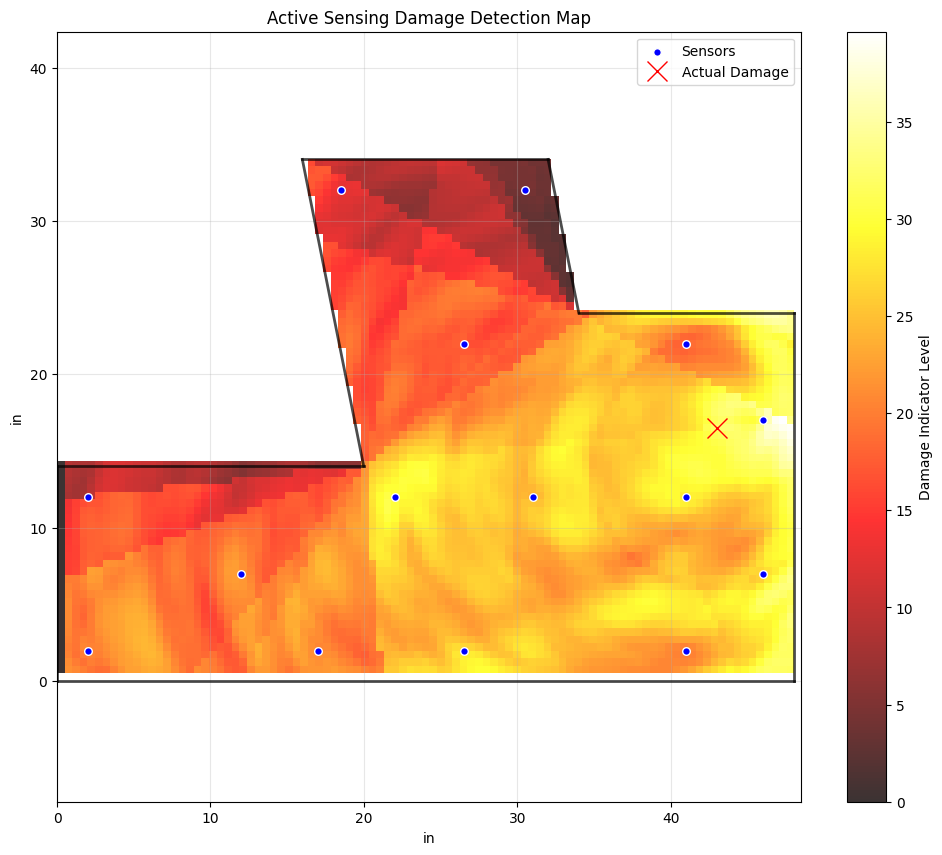


Active Sensing Feature Extraction Complete!
Maximum damage indicator: nan
Damage location: (43.0, 16.5) inches
Processing used 15 sensors in 105 pairs


In [22]:
# Plot 2D Map of POI levels
# MATLAB equivalent: plot2DMap_shm with additional sensor and border overlays

plt.figure(figsize=(12, 10))

# Create the 2D map plot
extent = [x_matrix.min(), x_matrix.max(), y_matrix.min(), y_matrix.max()]
im = plt.imshow(data_map_2d, extent=extent, origin='lower', cmap='hot', alpha=0.8)
plt.colorbar(im, label='Damage Indicator Level')

# Overlay border
if border_comb.size > 0 and border_comb.shape[0] == 4:
    for i in range(border_comb.shape[1]):
        x1, y1, x2, y2 = border_comb[:, i]
        plt.plot([x1, x2], [y1, y2], 'k-', linewidth=2, alpha=0.7)

# Overlay sensors
if sensor_layout_sub.shape[0] == 3:
    sensor_x_sub = sensor_layout_sub[1, :]
    sensor_y_sub = sensor_layout_sub[2, :]
else:
    sensor_x_sub = sensor_layout_sub[:, 1]
    sensor_y_sub = sensor_layout_sub[:, 2]

plt.scatter(sensor_x_sub, sensor_y_sub, c='blue', s=30, marker='o', 
           edgecolors='white', linewidth=1, label='Sensors')

# Overlay damage location
plt.plot(damage_x, damage_y, 'xr', markersize=15, linewidth=4, label='Actual Damage')

plt.xlabel('in')
plt.ylabel('in')
plt.title('Active Sensing Damage Detection Map')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nActive Sensing Feature Extraction Complete!")
print(f"Maximum damage indicator: {np.max(data_map_2d):.3e}")
print(f"Damage location: ({damage_x:.1f}, {damage_y:.1f}) inches")
print(f"Processing used {len(sensor_subset)} sensors in {pair_list_sub.shape[1]} pairs")